In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
from numba import jit
import scipy
from netCDF4 import Dataset


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

## utils

In [2]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

#rename weird ones
st_names = station_points['name'].copy()
st_names[3] = 'Las Vegas'
st_names[6] = 'Denver'
st_names[8] = 'Cincinnati'

In [81]:
#get CONUS lat/lons
ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_4.co.2p5.nc',
             mode="r")

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data
ds.close()

ny, nx = np.shape(lat_arr)

In [4]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lat_arr-station_lats[i]) + np.abs(lon_arr-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

conus_gp = (lat_idx, lon_idx)

In [5]:
def open_and_sum(files, ny, nx):
    #open each chunk of mswep files to get 24 precip totals for some number of days
    apcp_sums = np.zeros((ny,nx),dtype=np.float32)
    
    #sum to get 24 hour totals --> 8 files in a day
    for hour in range(8):
        f = files[hour]
        ds = Dataset(f, mode='r')
        apcp_var = ds.variables['precipitation']
        apcp = np.asarray(apcp_var[0])
        ds.close()
        apcp_sums += apcp
    return apcp_sums

# How to calculate?

First, from what data do we construct the diurnal precipitation cycle? Daily, monthly, 3 month window? I'll test the quality/strength of the signals below.

## test 1: only that day's data (over the span of 2002-2023)

In [6]:
#gather precip data for given month
precip_files=[]
month = 1
day = 15
for year in range(2002, 2024):
    t1 = datetime.datetime(year=year, month=month, day=day)
    doy = t1.strftime('%j')
    precip_files.append(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{year}/{year}{int(doy):03d}.*.nc')))


In [7]:
ds = xr.open_mfdataset(np.ravel(precip_files), combine='nested', concat_dim='time')

In [55]:
data = ds.precipitation.compute()

In [57]:
data.sum(dim='time')

<xarray.DataArray 'precipitation' (y: 1597, x: 2345)> Size: 15MB
array([[ 28.041931,  28.437439,  28.390747, ...,  25.038208,  25.00879 ,
         25.009583],
       [ 28.637085,  29.107727,  29.180664, ...,  25.13678 ,  25.108948,
         25.105469],
       [ 29.130615,  29.602417,  29.819336, ...,  25.249084,  25.170471,
         25.11316 ],
       ...,
       [106.84143 , 106.72894 , 106.661865, ...,  80.784   ,  80.88367 ,
         80.96484 ],
       [107.003296, 106.707214, 106.63745 , ...,  80.16986 ,  80.32825 ,
         80.79431 ],
       [107.16058 , 106.683716, 106.605896, ...,  79.00018 ,  78.63983 ,
         78.05585 ]], dtype=float32)
Coordinates:
  * x          (x) float32 9kB 0.0 2.54e+03 5.079e+03 ... 5.951e+06 5.953e+06
  * y          (y) float32 6kB 0.0 2.54e+03 5.079e+03 ... 4.051e+06 4.053e+06
    longitude  (y, x) float32 15MB 233.7 233.7 233.8 233.8 ... 300.9 300.9 301.0
    latitude   (y, x) float32 15MB 19.23 19.23 19.24 19.24 ... 54.38 54.38 54.37

Text(0.0485, 0.25, 'Precipitation [mm]')

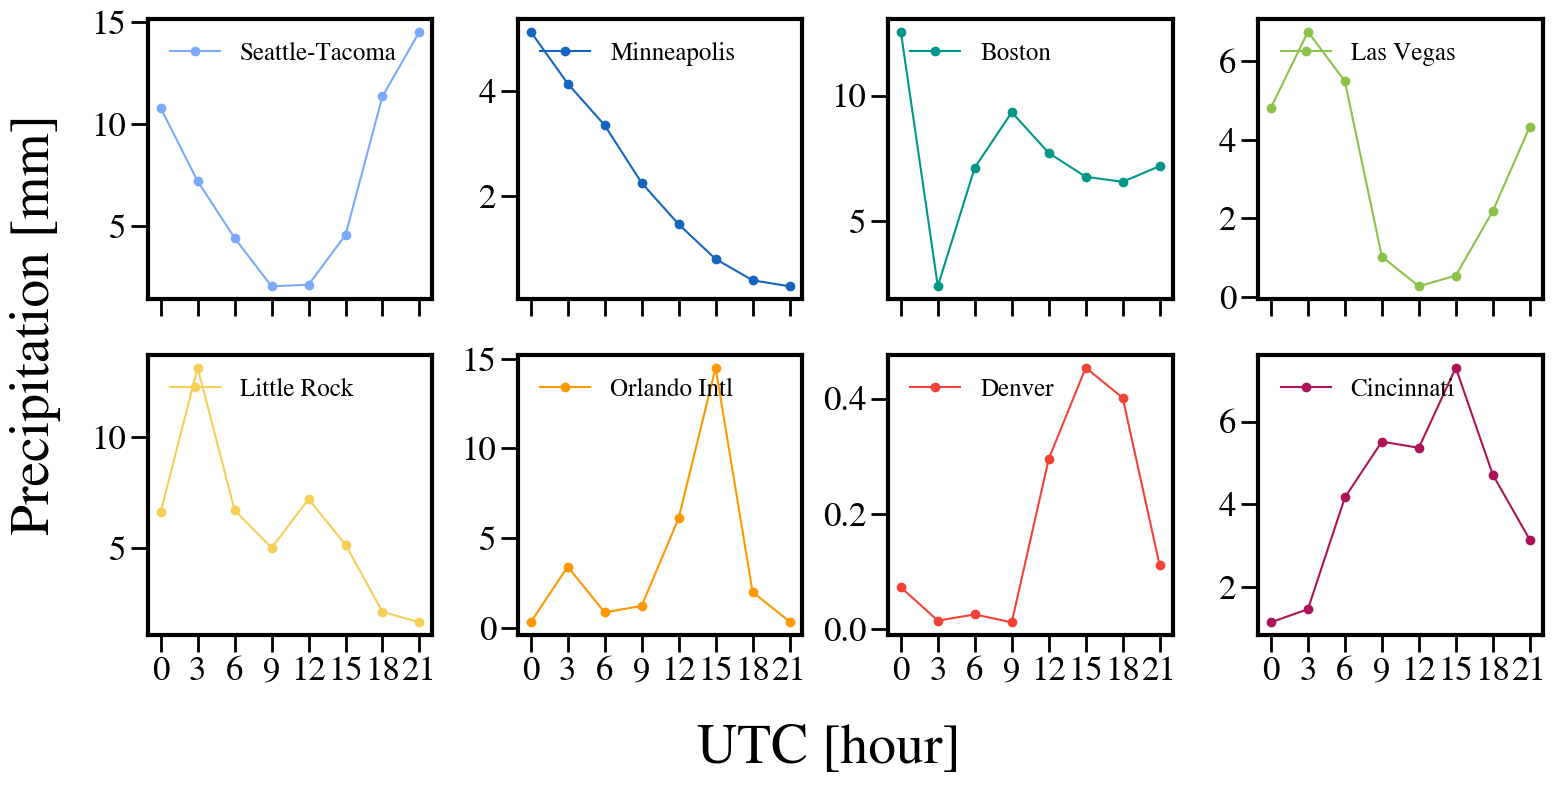

In [69]:
fig, axes = plt.subplots(2,4, sharex=True, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

hours = [0,3, 6, 9, 12, 15, 18, 21]
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        dp = []
        for h in range(len(hours)):
            this_hour = ds.time.dt.hour == hours[h]
            this_precip = data.sel(time=this_hour)
            p = this_precip.sum(dim='time').data[conus_gp[0][stat], conus_gp[1][stat]]
            dp.append(p)
        axes[i,j].plot(hours, dp, color=colors[stat], marker='o', label=st_names[stat].title())
        axes[i,j].legend(frameon=False, fontsize=18, loc='upper left')
        axes[i,j].set_xticks(hours)

fig.text(x=0.43, y=-0.05, s='UTC [hour]', fontdict={'fontsize': 40})
fig.text(x=0.0485, y=0.25, s='Precipitation [mm]', rotation='vertical',fontdict={'fontsize': 40})

## Dealing with time

MSWEP's native time unit is UTC...to make a diurnal cycle that actually reflects the daytime hours at each grid point, need to convert from UTC --> local time (probably via timezones instead of actual local solar time*). But since, e.g., 3z UTC is 10 pm eastern **the previous day** we need to be aware of when the days transition, because we'll need to pick up the previous day's or next day's data too. 

*There's also a discussion to be had about which time to convert to. Each grid point will have a unique local time (non-linearly dependent on lat/lon). Is it best to be as general as possible -- like converting to just the time defined by the time zone, which is just a function of longitude?

In [6]:
import timezonefinder, pytz

tf = timezonefinder.TimezoneFinder()

In [15]:
st_names

0      SEATTLE-TACOMA
1         MINNEAPOLIS
2              BOSTON
3           Las Vegas
4         LITTLE ROCK
5        ORLANDO INTL
6              Denver
7    DENVER STAPLETON
8          Cincinnati
Name: name, dtype: object

In [10]:
station_lats

0    47.4500
1    44.8833
2    42.3667
3    36.0833
4    34.7333
5    28.4333
6    39.8466
7    39.7500
8    39.0500
Name: lat, dtype: float64

In [7]:
lons180 = station_lons - 360

In [8]:
precip_files = []
month = 1
day = 15
for year in range(2002, 2024):
    t1 = datetime.datetime(year=year, month=month, day=day)
    t2 = datetime.datetime(year=year, month=month, day=day+1)
    for d in [t1, t2]:
        doy = d.strftime('%j')
        precip_files.append(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{year}/{year}{int(doy):03d}.*.nc')))

In [9]:
from dask.distributed import Client

client = Client(n_workers=32)

In [10]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 32
Total threads: 96,Total memory: 152.34 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33697,Workers: 32
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 152.34 GiB
Comm: tcp://127.0.0.1:43337,Total threads: 3
Dashboard: http://127.0.0.1:36749/status,Memory: 4.76 GiB
Nanny: tcp://127.0.0.1:32791,


In [11]:
ds = xr.open_mfdataset(np.ravel(precip_files), combine="nested", engine='h5netcdf',concat_dim='time', parallel=True)

In [16]:
ds.precipitation

<xarray.DataArray 'precipitation' (time: 352, y: 1597, x: 2345)> Size: 5GB
dask.array<concatenate, shape=(352, 1597, 2345), dtype=float32, chunksize=(1, 1597, 2345), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float32 9kB 0.0 2.54e+03 5.079e+03 ... 5.951e+06 5.953e+06
  * y          (y) float32 6kB 0.0 2.54e+03 5.079e+03 ... 4.051e+06 4.053e+06
  * time       (time) datetime64[ns] 3kB 2002-01-15 ... 2023-01-16T21:00:00
    longitude  (y, x) float32 15MB dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    latitude   (y, x) float32 15MB dask.array<chunksize=(1597, 2345), meta=np.ndarray>
Attributes:
    least_significant_digit:  4
    units:                    kg m-2
    standard_name:            precipitation_amount
    long_name:                MSWEP 3-hour Accumulated Precipitation Analysis
    valid_range:              [   0. 1000.]
    level:                    surface

In [12]:
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

In [34]:
hours = [0,3, 6, 9, 12, 15, 18, 21] #local
month = 1
to_utc = []

precip = np.zeros((len(st_names),len(hours)))
start = datetime.datetime.now()
for stat in range(len(st_names)):
    print(st_names[stat])
    # From the lat/long, get the tz-database-style time zone name (e.g. 'America/Vancouver') or None
    timezone_str = tf.certain_timezone_at(lat=station_lats[stat], lng=lons180[stat])
    #and get utc offset
    dtime = datetime.datetime.now(pytz.timezone(timezone_str))
    offset=dtime.utcoffset().total_seconds()/60/60 -1

    #determine nearest available MSWEP 3 hourly dataset for given station time zone
    for h in tqdm(hours):
        day = 15 #reset
        converted = np.abs(offset) + h
        if converted > 23:
            day += 1
            converted = converted % 24
        converted = hours[find_nearest(hours, converted)]
        t1 = datetime.datetime(year=year, month=month, day=day)
        doy = t1.strftime('%j')
        files = sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/*/*{int(doy):03d}.{converted:02d}.nc'))

        #add precip values from 2002-2023 for given hour
        for f in files:
            ds = Dataset(f, mode='r')
            apcp_var = ds.variables['precipitation']
            apcp = np.asarray(apcp_var[0])[conus_gp[0][stat], conus_gp[1][stat]]
            ds.close()
            precip[stat, hours.index(h)] += apcp

finish = datetime.datetime.now()
print(f'Finished in {(finish-start).total_seconds()}')

SEATTLE-TACOMA


  0%|          | 0/8 [00:00<?, ?it/s]

MINNEAPOLIS


  0%|          | 0/8 [00:00<?, ?it/s]

BOSTON


  0%|          | 0/8 [00:00<?, ?it/s]

Las Vegas


  0%|          | 0/8 [00:00<?, ?it/s]

LITTLE ROCK


  0%|          | 0/8 [00:00<?, ?it/s]

ORLANDO INTL


  0%|          | 0/8 [00:00<?, ?it/s]

Denver


  0%|          | 0/8 [00:00<?, ?it/s]

DENVER STAPLETON


  0%|          | 0/8 [00:00<?, ?it/s]

Cincinnati


  0%|          | 0/8 [00:00<?, ?it/s]

Finished in 128.270921


Text(0.0485, 0.25, 'Precipitation [mm]')

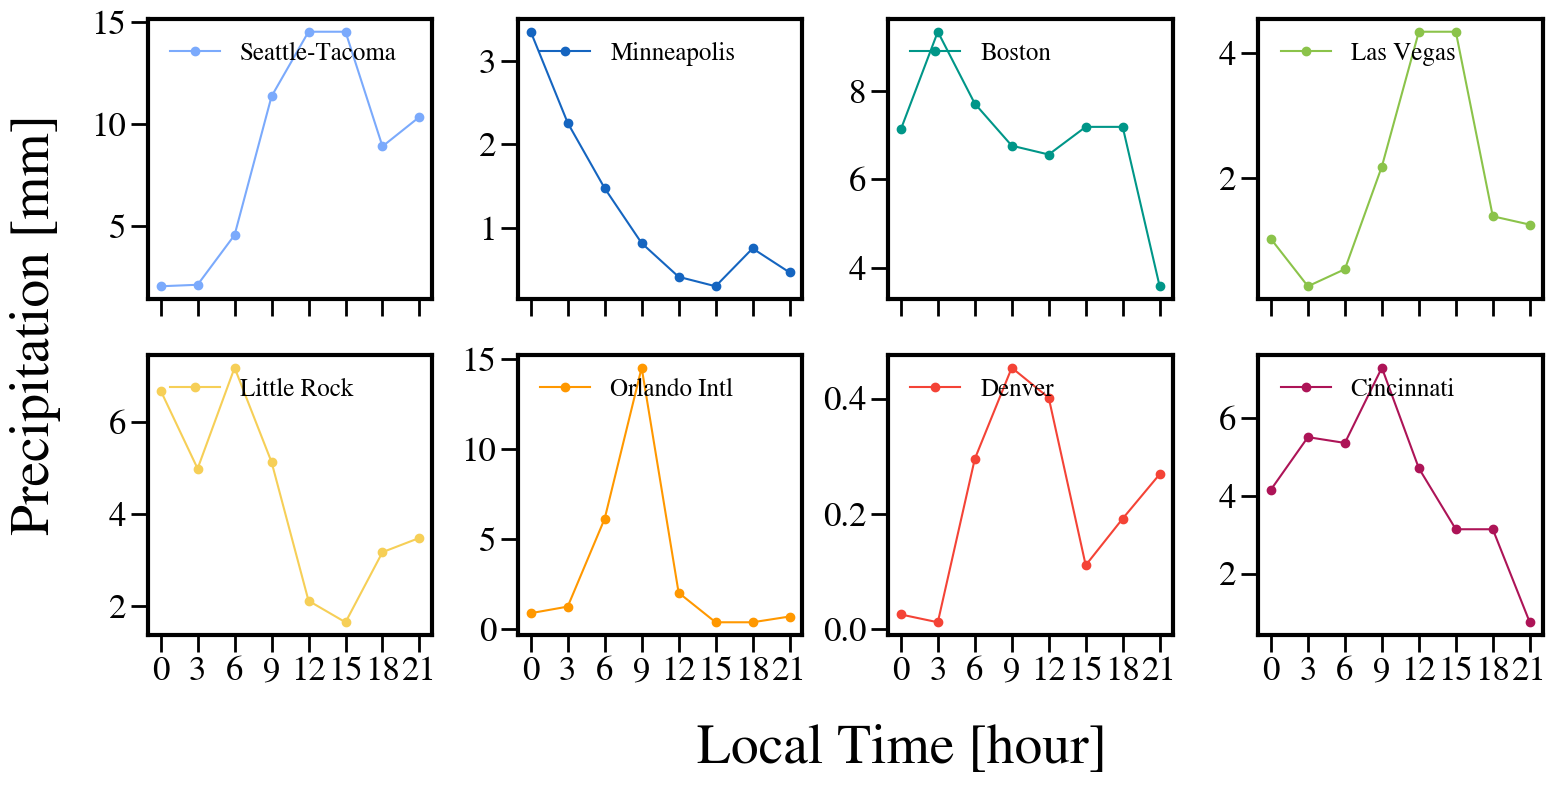

In [37]:
fig, axes = plt.subplots(2,4, sharex=True, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

hours = [0,3, 6, 9, 12, 15, 18, 21]
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].plot(hours, precip[stat], color=colors[stat], marker='o', label=st_names[stat].title())
        axes[i,j].legend(frameon=False, fontsize=18, loc='upper left')
        axes[i,j].set_xticks(hours)

fig.text(x=0.43, y=-0.05, s='Local Time [hour]', fontdict={'fontsize': 40})
fig.text(x=0.0485, y=0.25, s='Precipitation [mm]', rotation='vertical',fontdict={'fontsize': 40})

In [15]:
np.shape(out
        ) #num days = 22

(22, 1597, 2345)

## confirmation: diurnal cycle should be calculate over same 3 month window as the climo gamma params

In [ ]:
def collect_files(time_zone, month, domain):
    """
    Revised version of collect_files in blend-qmd-dev/precip_climo_gamma_parameters/blend_precip_climo_gamma_parameters-SL/calc_utils.py
    to account for shifting from UTC to local time, 
    so files that need to be loaded are now dependent
    on grid point location
    
    """
    
    file_list = []
    for i in range(year, year+1):
        chosen_date = datetime.datetime(year=i, month=month, day=1)
        #logic for determining prev/next months
        if month == 1:
            prev_month = 12
            prev_year = i-1
            next_month = month+1
            next_year = i
        elif month == 12:
            prev_month = month-1
            prev_year = i
            next_month = 1
            next_year = i+1
        elif (month == 12) and (i == 2023):
            prev_month = month-1
            prev_year = i
            next_month = month
            next_year = i
        elif (month == 1) and (i == 2002):
            prev_month = month
            prev_year = i
            next_month = month+1
            next_year = i
        else:
            prev_month = month-1
            prev_year = i
            next_month = month+1
            next_year = i
    
        #determine which days of year correspond to chosen month
        date_touples = [(prev_month, prev_year), (month, i), (next_month, next_year)]
        for datet in date_touples:
            m, y = datet[0], datet[1]
            dt = datetime.datetime(year=y, month=m, day=1)
            this_doy = dt.strftime('%Y%j')
            start = int(this_doy[4:])
            end = start+pd.Period(f'{y}-{m}-1').daysinmonth-1 #how does datetime not have a # of days in month func??
            path = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/{y}/"
            expected_files = [path+f"{y}"+"{:03}.*.nc".format(j) for j in range(start, end+1)]
            for file_ in expected_files:
                file_list.append(sorted(glob(file_)))
    #clean up nested list structure
    mswep_paths = [
        x
        for xs in file_list
        for x in xs
    ]

    mswep_paths = np.unique(mswep_paths)

    #make list of lists to separate files by day
    mswep_files = [mswep_paths[8*i:8*(1+i)] for i in range(int(len(mswep_paths)/8))]
    
    return mswep_files

In [40]:
files_for_timezone = dict(America/Los_Angeles, 'America/Denver','America/Chicago','America/New_York'))

In [46]:
files_for_timezone = xr.Dataset(
    data_vars=dict(
        files=(["timezone"], [0,0,0,0])
    ),
    coords=dict(
        timezone=['America/Los_Angeles', 'America/Denver','America/Chicago','America/New_York']
    ))

In [49]:
files_for_timezone.timezone.data

array(['America/Los_Angeles', 'America/Denver', 'America/Chicago',
       'America/New_York'], dtype='<U19')

In [53]:
hours = [0,3, 6, 9, 12, 15, 18, 21] #local
month = 1
to_utc = []

precip = np.zeros((len(st_names),len(hours)))
for tz in files_for_timezone.timezone.data:
    print(tz)
    # From the lat/long, get the tz-database-style time zone name (e.g. 'America/Vancouver') or None
    #timezone_str = tf.certain_timezone_at(lat=station_lats[stat], lng=lons180[stat])
    #and get utc offset
    dtime = datetime.datetime.now(pytz.timezone(tz))
    offset=dtime.utcoffset().total_seconds()/60/60 -1
    start_hour = np.abs(offset)
    print(f'    Actual start hour: {start_hour}')
    start_hour = hours[find_nearest(hours, start_hour)]
    print(f'    Closest start hour: {start_hour}')
    

America/Los_Angeles
    Actual start hour: 8.0
    Closest start hour: 9
America/Denver
    Actual start hour: 7.0
    Closest start hour: 6
America/Chicago
    Actual start hour: 6.0
    Closest start hour: 6
America/New_York
    Actual start hour: 5.0
    Closest start hour: 6


In [ ]:
    #determine nearest available MSWEP 3 hourly dataset for given time zone
    files = []
    for h in tqdm(hours):
        for year in range(2002,2024):
            chosen_date = datetime.datetime(year=year, month=month, day=1)
            #logic for determining prev/next months
            if month == 1:
                prev_month = 12
                prev_year = i-1
                next_month = month+1
                next_year = i
            elif month == 12:
                prev_month = month-1
                prev_year = i
                next_month = 1
                next_year = i+1
            elif (month == 12) and (i == 2023):
                prev_month = month-1
                prev_year = i
                next_month = month
                next_year = i
            elif (month == 1) and (i == 2002):
                prev_month = month
                prev_year = i
                next_month = month+1
                next_year = i
            else:
                prev_month = month-1
                prev_year = i
                next_month = month+1
                next_year = i
            date_touples = [(prev_month, prev_year), (month, i), (next_month, next_year)]
            for datet in date_touples:
                m, y = datet[0], datet[1]
                dt = datetime.datetime(year=y, month=m, day=1)
                this_doy = dt.strftime('%Y%j')
                start = int(this_doy[4:])
                end = start+pd.Period(f'{y}-{m}-1').daysinmonth-1

        
        converted = np.abs(offset) + h
        if converted > 23:
            day += 1
            converted = converted % 24
        converted = hours[find_nearest(hours, converted)]
        t1 = datetime.datetime(year=year, month=month, day=day)
        doy = t1.strftime('%j')
        files.append(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/*/*{int(doy):03d}.{converted:02d}.nc')))
    #files_for_timezone[tz] = files

## wait a gd minute

Ok so the UTC offsets in CONUS span -8 to -5. But we only have 3 hourly MSWEP data, so I have to map from local time hour 0 to nearest available MSWEP 3 hourly file. So, for instance, if we're looking at Seattle, to collect data for local time hour 0, we need the 8z data, but that doesn't exist! So we instead use the 9z data.

That means Mountain, Central, and Eastern time zones all use the same MSWEP data (since offsets of -7, -6, -5 all map to the 6z MSWEP file). So those grid points will all have the same time shift. 

But wait. The entire point in the first place in constructing the diurnal cycle based on local time was to accurately compare precip trends that depend **on local time**. If SLs are constrained by some max separation that could really only span (at most) 1 time zone difference. Does it matter at all (with the data we have) whether we convert from UTC to local time? I am beginning to think not.

# For real this time: diurnal cycle from 3 month window

In [54]:
def open_and_sum(files, ny, nx):
    apcp_sums = np.zeros((ny,nx),dtype=np.float32)
    
    #sum given hour for each day/year
    for day in range(len(files)):
        f = files[day]
        ds = Dataset(f, mode='r')
        apcp_var = ds.variables['precipitation']
        apcp = np.asarray(apcp_var[0])
        ds.close()
        apcp_sums += apcp
    return apcp_sums

In [76]:
def collect_files(month, domain):
    file_list = []
    for i in range(2002, 2003):
        chosen_date = datetime.datetime(year=i, month=month, day=1)
        #logic for determining prev/next months
        if month == 1:
            prev_month = 12
            prev_year = i-1
            next_month = month+1
            next_year = i
        elif month == 12:
            prev_month = month-1
            prev_year = i
            next_month = 1
            next_year = i+1
        elif (month == 12) and (i == 2023):
            prev_month = month-1
            prev_year = i
            next_month = month
            next_year = i
        elif (month == 1) and (i == 2002):
            prev_month = month
            prev_year = i
            next_month = month+1
            next_year = i
        else:
            prev_month = month-1
            prev_year = i
            next_month = month+1
            next_year = i
    
        #determine which days of year correspond to chosen month
        date_touples = [(prev_month, prev_year), (month, i), (next_month, next_year)]
        for datet in date_touples:
            m, y = datet[0], datet[1]
            dt = datetime.datetime(year=y, month=m, day=1)
            this_doy = dt.strftime('%Y%j')
            start = int(this_doy[4:])
            end = start+pd.Period(f'{y}-{m}-1').daysinmonth-1 #how does datetime not have a # of days in month func??
            path = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/{domain}/{y}/"
            expected_files = [path+f"{y}"+"{:03}.*.nc".format(j) for j in range(start, end+1)]
            for file_ in expected_files:
                file_list.append(sorted(glob(file_)))
    #clean up nested list structure
    mswep_paths = [
        x
        for xs in file_list
        for x in xs
    ]

    mswep_paths = np.unique(mswep_paths)

    #make list of lists to separate files by hour
    mswep_files = [mswep_paths[i::8] for i in range(8)]
    
    return mswep_files

In [92]:
precip_files = collect_files(7, 'co')

In [93]:
n_processes = 16

print('Processing files, making daily sums')
start = datetime.datetime.now()
print(f'    Using {n_processes} CPUs')
with multiprocessing.Pool(n_processes) as P:
    out = P.starmap(open_and_sum, zip(precip_files, np.repeat(ny, len(precip_files)), np.repeat(nx, len(precip_files))))
out = np.asarray(out)
end=datetime.datetime.now()
print(f'    Finished in {(end-start).total_seconds()}s')
P.close()

Processing files, making daily sums
    Using 16 CPUs
    Finished in 14.027015s


In [89]:
np.shape(out)

(8, 1597, 2345)

Text(0.0485, 0.25, 'Precipitation [mm]')

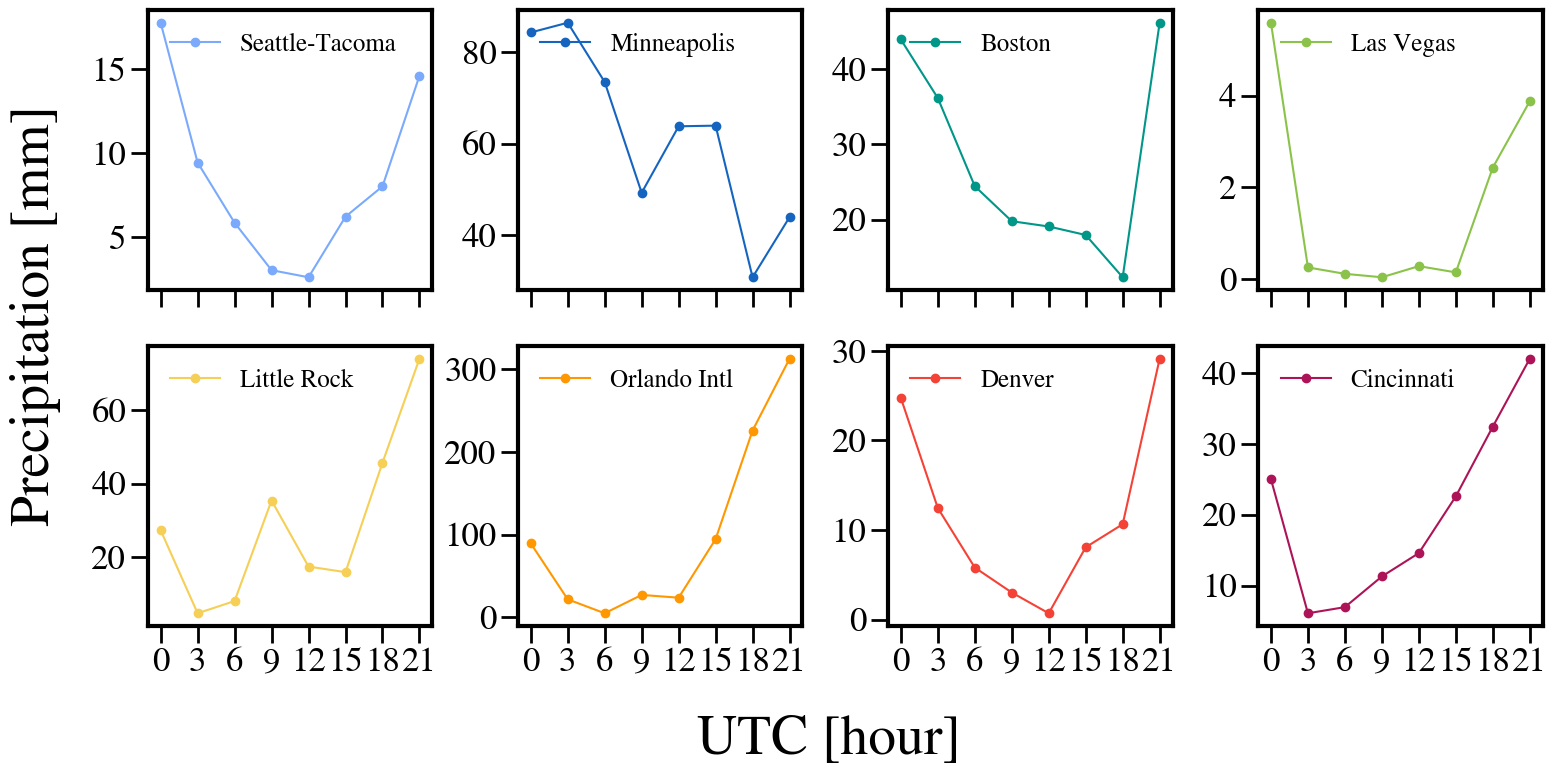

In [94]:
fig, axes = plt.subplots(2,4, sharex=True, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

hours = [0,3, 6, 9, 12, 15, 18, 21]
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].plot(hours, out[:,conus_gp[0][stat], conus_gp[1][stat]], color=colors[stat], marker='o', label=st_names[stat].title())
        axes[i,j].legend(frameon=False, fontsize=18, loc='upper left')
        axes[i,j].set_xticks(hours)

fig.text(x=0.43, y=-0.05, s='UTC [hour]', fontdict={'fontsize': 40})
fig.text(x=0.0485, y=0.25, s='Precipitation [mm]', rotation='vertical',fontdict={'fontsize': 40})

## determining params to describe diurnal cycle